In [1]:
import os
import math
import torch
import random
import torchaudio
from tqdm import tqdm
import torch.nn.functional as F
from dit_main import DiffusionTransformer
from config.model.config import config
from train.dataset import SampleDataset
from condition.t5condition import T5Conditioner
from train.validation import validate_or_test
from train.utils import draw_plot, cleanup_memory, save_concatenated_mel_spectrogram, calculate_targets, prepare_batch_data, masked_loss
from vae.get_function import create_autoencoder_from_config
from torch.cuda.amp import autocast, GradScaler
from inference.inference import generation
from utils import get_span_mask, prob_mask_like
from accelerate import Accelerator, DistributedDataParallelKwargs
from safetensors.torch import load_file, save_file
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from torch.utils.data import Dataset, DataLoader, RandomSampler
from train.dataset import Config

device = 'cuda'

In [2]:
model = DiffusionTransformer(
    d_model          = 1536,
    depth            = 24,
    num_heads        = 24,
    input_concat_dim = 0,
    global_cond_type = 'prepend',
    latent_channels  = 64, 
    config           = config, 
    device           = device,
    ada_cond_dim     = None,
    use_skip         = False,
    is_melody_prompt = True
)
model = model.to(device)

text_conditioner = T5Conditioner(output_dim=768).to(device)
ae = create_autoencoder_from_config(config['auto_encoder_config']).to(device)

ae.eval()
text_conditioner.eval()
model.eval()

num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_trainable_params)

Load pretrained t5 encoder


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


1057238400


In [4]:
# model.load_state_dict(torch.load('./totlamodel.pth'))
pre_model_dir = '/workspace/mel_con_sample/pretrained2'

state_dict = torch.load(f'{pre_model_dir}/transformer_weight.pth')

clean_state_dict = {layer_name.replace('ff.ff.0', 'ff.linear_in'): weights for layer_name, weights in state_dict.items()}
clean_state_dict = {layer_name.replace('ff.ff.2', 'ff.linear_out'): weights for layer_name, weights in clean_state_dict.items()}

model.model.load_state_dict(clean_state_dict)

s1 = torch.load(f'{pre_model_dir}/preprocess_conv.pth')
s2 = torch.load(f'{pre_model_dir}/postprocess_conv.pth')
s3 = torch.load(f'{pre_model_dir}/to_cond_embed.pth')
s4 = torch.load(f'{pre_model_dir}/to_global_embed.pth')
s5 = torch.load(f'{pre_model_dir}/to_timestep_embed.pth')

del clean_state_dict
del state_dict
torch.cuda.empty_cache()

model.preprocess_conv.load_state_dict(s1)
model.postprocess_conv.load_state_dict(s2)
model.to_cond_embed.load_state_dict(s3)
model.to_global_embed.load_state_dict(s4)
model.to_timestep_embed.load_state_dict(s5)

ss = torch.load(f'{pre_model_dir}/sec_start.pth')
model.timing_start_conditioner.load_state_dict(ss)

st = torch.load(f'{pre_model_dir}/sec_total.pth')
model.timing_total_conditioner.load_state_dict(st)
model.timing_total_conditioner.load_state_dict(st)

model.fourier.load_state_dict(torch.load(f'{pre_model_dir}/timestep_features.pth'))

text_conditioner.proj_out.load_state_dict(torch.load(f'{pre_model_dir}/text_conditioner.pth'))

del ss
del st
del s1
del s2
del s3
del s4
del s5
torch.cuda.empty_cache()

ae_state_dict = torch.load(f'{pre_model_dir}/vae_weight.pth')
ae_clean_state_dict = {layer_name.replace('model.', ''): weights for layer_name, weights in ae_state_dict.items()}

ae.load_state_dict(ae_clean_state_dict)

del ae_clean_state_dict
del ae_state_dict
torch.cuda.empty_cache()

torch.save(model.state_dict(), './total_model2.pth')

In [7]:
cfg = {
    "sample_steps": 100,
    "sample_cfg": 7.0,
    "sample_duration": 8.0,
    "sample_rate": 44100,
    "diffusion_objective": "v"
}

output = generation(
    model,
    ae,
    text_conditioner,
    text="prompts : hip-hop, drums, loop, bpm: 150",
    steps=cfg['sample_steps'],
    cfg_scale=cfg['sample_cfg'],
    duration=cfg['sample_duration'],
    sample_rate=cfg['sample_rate'],
    batch_size=1,
    device=device,
    disable=False,
    train_duration=10.0
)
print(output.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 2, 440320])



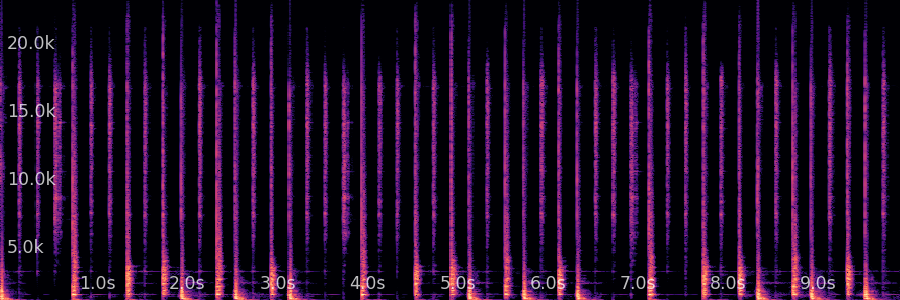
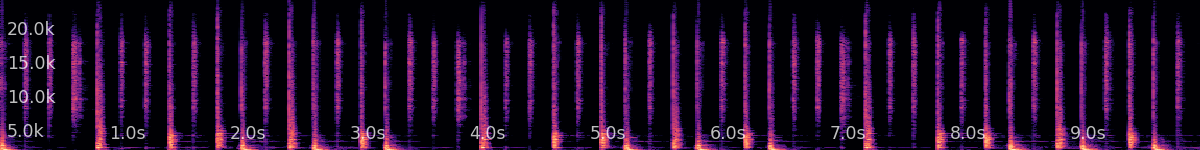

In [8]:
from audiotools import AudioSignal

AudioSignal(output[0].cpu().numpy(), sample_rate=44100).widget()